In [1]:

# import mlflow

import os
import sys
import networkx as nx
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString,Point
import numpy as np
import matplotlib.pyplot as plt
# import bokeh as bh

from datetime import datetime
import taxi_driver.taxi_driver as td


import sklearn.metrics as skm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# mlflow.sklearn.autolog()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

%load_ext autoreload
%autoreload 2

In [2]:
#setting some much needed paths 

dataPath = os.path.join("data")
csvPath  = os.path.join(dataPath,"CSV")
shpPath  = os.path.join(dataPath,"SHP")

outputPath = os.path.join("outputs")
imagePath = os.path.join(outputPath,"images")



In [3]:
zoneShpPath = os.path.join(shpPath,"taxi_zones.shp")

#combine in one
# march_path = os.path.join(csvPath,"march_data.csv")
# june_path = os.path.join(csvPath,"june_data.csv")
# nov_path = os.path.join(csvPath,"november_data.csv")

# taxi_df=td.Taxidf([march_path,june_path,nov_path],sample_fraction=0.2,taxi_zones_shp_path=zoneShpPath)
#taxi_df.convert_dates()

#save the combined sample df
# csv_sample_path = os.path.join(csvPath,"sample_csv.csv")
# taxi_df.taxi_data.to_csv(csv_sample_path)
#---------------------------------------------------

#load the sample
csv_sample_path = os.path.join(dataPath,"yellow_tripdata_2025-01.parquet")
taxi_df=td.Taxidf(csv_sample_path,taxi_zones_shp_path=zoneShpPath)
taxi_df.convert_dates()

/media/itoumpalidis/SlowHDD/linux_part/t2l/nyc_taxi_tips/taxi_driver/taxi_driver.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.taxi_data=pd.concat([self.taxi_data,temp_df])


Sampling the main dataset by selecting only the trips payed with card, tip amount, trip distance and fare amount
that are non negative.

## Spatial regression 

In [663]:
from sklearn.preprocessing import FunctionTransformer
from spreg import ML_Lag

taxi_df.compute_taxi_zones()

coordsDict = dict(zip(taxi_df.taxi_zones['PULocationID'],list(zip(long,lat))))

groupedDf = clean_df.groupby(['PULocationID','DOLocationID','set_tip_amount_flag','pickup_time','dropoff_time'])[['fare_amount','tip_amount']].mean().reset_index()
groupedDf['PUCoords']=groupedDf['PULocationID'].apply(lambda x:coordsDict[x] if x in coordsDict.keys() else None)
groupedDf[['PULong','PULat']]=pd.DataFrame(groupedDf['PUCoords'].tolist())
groupedDf=groupedDf.dropna()

groupedDf['DOCoords']=groupedDf['DOLocationID'].apply(lambda x:coordsDict[x] if x in coordsDict.keys() else None)
groupedDf[['DOLong','DOLat']]=pd.DataFrame(groupedDf['PUCoords'].tolist())
groupedDf=groupedDf.dropna()


coords = groupedDf[['PULong', 'PULat']].values
w = KNN.from_array(coords, k=5)

# Encode hour as Fourier series
groupedDf['pu_hour_sin'] = np.sin(2 * np.pi * groupedDf['pu_hour'] / 24)
groupedDf['pu_hour_cos'] = np.cos(2 * np.pi * groupedDf['pu_hour'] / 24)

y = groupedDf['set_tip_amount_flag']
X = groupedDf[['fare_amount','pu_hour_sin','pu_hour_cos']]

model = ML_Lag(y, X, w=w)

# View summary
print(model.summary)

## Data Processing / Feature Engineering

In [20]:
clean_df=taxi_df.taxi_data.copy()

In [69]:
import holidays
us_holidays = holidays.UnitedStates()
grouped_date=taxi_df.grouped_date()
holidays=[datetime.strptime(i,"%Y-%m-%d") in grouped_date for i in list (grouped_date.index)] 

if(not True in holidays):
    print("there are no holidays in the data set")
else:
    print("check for the holidays")

there are no holidays in the data set


Introduce some new features that might help on the modelling

In [21]:
clean_df['dollar_per_mile']=clean_df['fare_amount']/clean_df['trip_distance']
clean_df['tip_to_fare']=clean_df['tip_amount']/clean_df['fare_amount']
clean_df['duration_s']=(clean_df['tpep_dropoff_datetime']-clean_df['tpep_pickup_datetime']).apply(lambda x:x.seconds)
clean_df['speed_kpi']=clean_df['trip_distance']/clean_df['duration_s']

mod_tip = clean_df['tip_amount']%1
clean_df['set_tip_amount_flag']=mod_tip.apply(lambda x:0 if x==0 else 1)


In [40]:
clean_df['Airport_flag']=clean_df['Airport_fee'].apply(lambda x: 0 if x==0 else 1)
clean_df['congestion_surcharge_flag']=clean_df['congestion_surcharge'].apply(lambda x: 0 if x==0 else 1)
clean_df['mta_tax_flag']=clean_df['mta_tax'].apply(lambda x: 0 if x==0 else 1)

In [38]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore',sparse_output=False)
spatial_array = encoder.fit_transform(clean_df[['PULocationID','DOLocationID']])


filter out outliers 

In [22]:
#select for now only one vendor id
clean_df = clean_df[clean_df['VendorID']==2]


#will keep only the payment checks
clean_df = clean_df[clean_df['payment_type']==1]

# I will create a sample of only the non_negative
clean_df= clean_df[clean_df['tip_amount']>0]
clean_df= clean_df[clean_df['trip_distance']>0]

# duration >0
clean_df = clean_df[clean_df['duration_s']>0]


#controlling the value between >0 
clean_df=clean_df.loc[(clean_df['fare_amount']>0)]


# tip <100% of the price of the ride
clean_df=clean_df[clean_df['tip_to_fare']<1]

clean_df = clean_df.dropna()

## Classification problem structure

It might be possible to work on a pipeline of two models where the first one classifies if the trip would be more propable to have a set amount regardless the total fare amount and the ones that have a percentage 

In [604]:
import xgboost as xgb
from sklearn.metrics import accuracy_score,f1_score

model = xgb.XGBClassifier()
model.fit(X[:-4637], y[:-4637])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [606]:

X_valid = X[-4637:]
y_valid = y[-4637:]
pred = model.predict(X_valid)

accuracy = f1_score(pred,y_valid)
print(accuracy)

0.6270767055496642


In [607]:
accuracy_score(pred,y_valid)

0.5449644166486953

## Temporal analysis of the tip amount

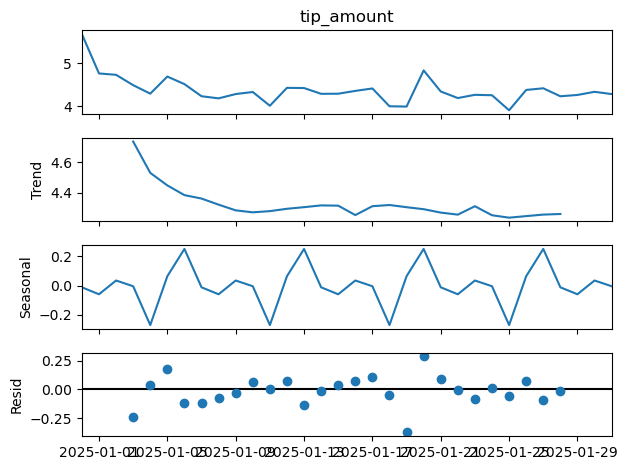

In [453]:
from statsmodels.tsa.seasonal import seasonal_decompose
daily_tips = clean_df.groupby(clean_df['tpep_pickup_datetime'].dt.date)['tip_amount'].mean()

result = seasonal_decompose(daily_tips, model='additive', period=7)
result.plot()
plt.show()

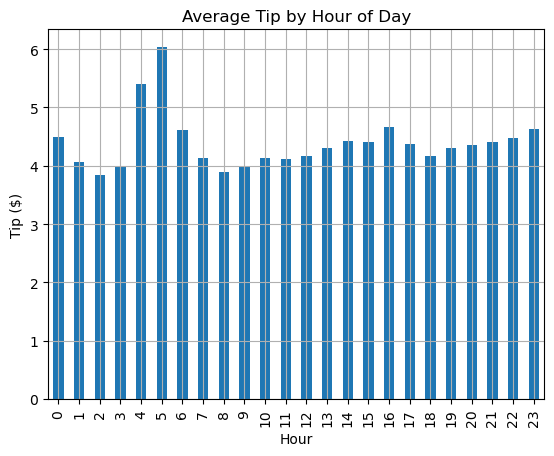

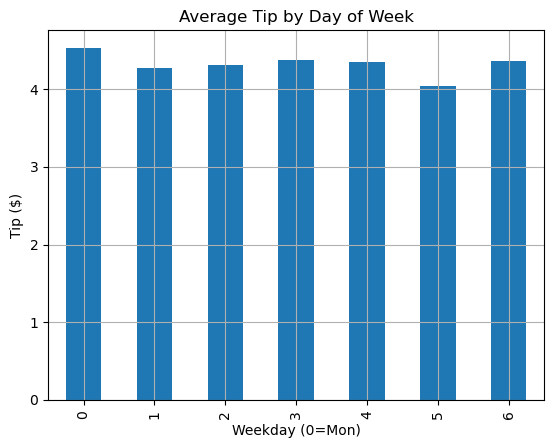

In [446]:
# Hour of Day
hourly_avg = clean_df.groupby('pu_hour')['tip_amount'].mean()
hourly_avg.plot(kind='bar', title='Average Tip by Hour of Day')
plt.ylabel('Tip ($)')
plt.xlabel('Hour')
plt.grid(True)
plt.show()

# Day of Week
weekday_avg = clean_df.groupby('pu_day')['tip_amount'].mean()
weekday_avg.plot(kind='bar', title='Average Tip by Day of Week')
plt.ylabel('Tip ($)')
plt.xlabel('Weekday (0=Mon)')
plt.grid(True)
plt.show()

In [448]:
from scipy.stats import spearmanr

# Convert dates to ordinal (numeric time)
time_numeric = clean_df['tpep_pickup_datetime'].map(pd.Timestamp.toordinal)
corr, pval = spearmanr(time_numeric, clean_df['tip_amount'])

print(f"Spearman Correlation: {corr:.4f}, p-value: {pval:.4e}")

Spearman Correlation: -0.0029, p-value: 1.4924e-05


In [38]:
Q1 = clean_df['tip_to_fare'].quantile(0.25)
Q3 = clean_df['tip_to_fare'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

# Check how many values exceed the upper bound
print(f"Upper bound: {upper_bound}")
print((clean_df['tip_to_fare'] > upper_bound).mean())

# Filter based on IQR outlier threshold
clean_df = clean_df[clean_df['tip_to_fare'] <= upper_bound]

Upper bound: 0.4701778105539167
0.029458876636470604


## Establishing base lines

In [48]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import cross_val_score


In [43]:

corr = clean_df[["tip_to_fare","tip_amount",'passenger_count',"trip_distance","fare_amount","duration_s",'Airport_flag','congestion_surcharge_flag','mta_tax_flag']].corr()
corr.style.background_gradient(cmap='coolwarm')

,tip_to_fare,tip_amount,passenger_count,trip_distance,fare_amount,duration_s,Airport_flag,congestion_surcharge_flag,mta_tax_flag
tip_to_fare,1.000000,0.055972,-0.007824,-0.204626,-0.299501,-0.141636,-0.131250,0.113391,0.066121
tip_amount,0.055972,1.000000,0.045399,0.645638,0.864457,0.305812,0.595979,-0.294938,-0.284097
passenger_count,-0.007824,0.045399,1.000000,0.033759,0.051557,0.027377,0.016728,-0.010645,-0.043426
trip_distance,-0.204626,0.645638,0.033759,1.000000,0.736778,0.260143,0.545822,-0.270007,-0.152417
fare_amount,-0.299501,0.864457,0.051557,0.736778,1.000000,0.348904,0.645540,-0.372686,-0.349250
duration_s,-0.141636,0.305812,0.027377,0.260143,0.348904,1.000000,0.219882,-0.091542,-0.047427
Airport_flag,-0.131250,0.595979,0.016728,0.545822,0.645540,0.219882,1.000000,-0.427711,-0.074960
congestion_surcharge_flag,0.113391,-0.294938,-0.010645,-0.270007,-0.372686,-0.091542,-0.427711,1.000000,0.279849
mta_tax_flag,0.066121,-0.284097,-0.043426,-0.152417,-0.349250,-0.047427,-0.074960,0.279849,1.000000


My first intuition looking the highly correlated values of tip amount and fare_amount,trip_distance is to try to fit a linear model on the data and see how it behaves. So first we will create a simple linear regression model that will be our base model. Did a test with fare amount and trip duration but the coefficient for the trip duration was extremly low. 

In [24]:
# fileName = "clean_sample.csv"
# filePath = os.path.join(csvPath,fileName)
clean_df.to_csv('./data/clean_sample.csv')
clean_df=pd.read_csv('./data/clean_sample.csv')

In [71]:
#split the df two to parts 


X=clean_df[["fare_amount",'Airport_flag','trip_distance','congestion_surcharge_flag','mta_tax_flag']]
y=clean_df[["tip_amount"]]


In [72]:

# 🪓 Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 📊 Baseline 1: Dummy Mean Regressor
mean_model = DummyRegressor(strategy="mean")
mean_model.fit(X_train, y_train)
y_pred_mean = mean_model.predict(X_test)

# 📊 Baseline 2: Dummy Median Regressor
median_model = DummyRegressor(strategy="median")
median_model.fit(X_train, y_train)
y_pred_median = median_model.predict(X_test)

# 📈 Baseline 3: Linear Regression
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred_linreg = linreg.predict(X_test)

# 🌳 Baseline 4: Simple Decision Tree
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

# 📋 Evaluation Function
def eval_model(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name:<20} | MSE: {mse:.4f} | R²: {r2:.4f}")

# 🧾 Report
print("Model Evaluation:")
eval_model("Dummy Mean", y_test, y_pred_mean)
eval_model("Dummy Median", y_test, y_pred_median)
eval_model("Linear Regression", y_test, y_pred_linreg)
eval_model("Decision Tree", y_test, y_pred_tree)

Model Evaluation:
Dummy Mean           | MSE: 13.8305 | R²: -0.0000
Dummy Median         | MSE: 14.9787 | R²: -0.0830
Linear Regression    | MSE: 3.3939 | R²: 0.7546
Decision Tree        | MSE: 3.6095 | R²: 0.7390


From our first experiment, we can observe that we can achieve good results in MSE and R² with LR and DT to achieve very similar results,which can be verified also with some additional cross validation.

In [87]:

coef =linreg.coef_[0]
for idx,name in enumerate(X_test.columns):
    
    print(f"{name:<20} | coef: {coef[idx]:.4f} ")

fare_amount          | coef: 0.1831 
Airport_flag         | coef: 1.1305 
trip_distance        | coef: 0.0032 
congestion_surcharge_flag | coef: 0.8810 
mta_tax_flag         | coef: -0.1171 


In [76]:
print(cross_val_score(linreg, X, y, scoring='r2', cv=5))
print(cross_val_score(tree, X, y, scoring='r2', cv=5))

[0.74481462 0.75933672 0.75041492 0.7562722  0.74517815]
[0.72881719 0.74205177 0.73221724 0.73916309 0.72812333]


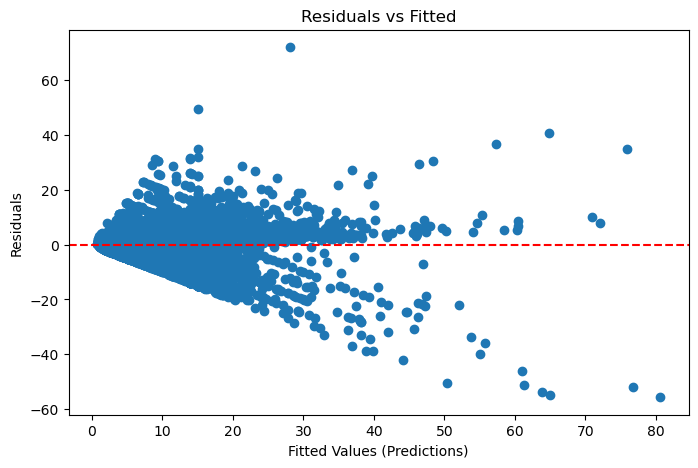

In [73]:


predicted_tip=linreg.predict(X_test)
residuals = y_test['tip_amount'] - predicted_tip.flatten()

plt.figure(figsize=(8, 5))
plt.scatter(predicted_tip, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values (Predictions)')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.show()

(array([7.00000e+00, 1.40000e+01, 7.90000e+01, 5.93400e+03, 3.50094e+05,
        8.60000e+02, 4.10000e+01, 4.00000e+00, 1.00000e+00, 1.00000e+00]),
 array([-55.64417599, -42.89186864, -30.13956129, -17.38725393,
         -4.63494658,   8.11736077,  20.86966813,  33.62197548,
         46.37428283,  59.12659018,  71.87889754]),
 <BarContainer object of 10 artists>)

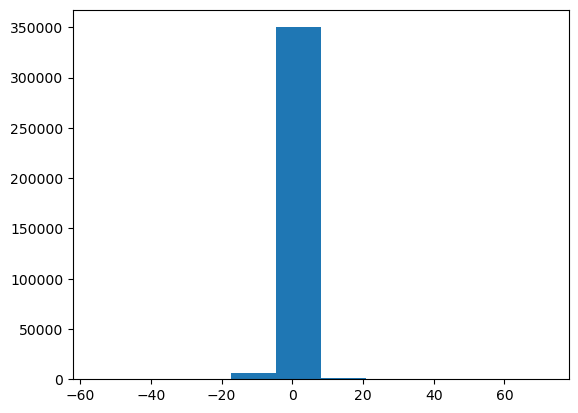

In [78]:
plt.hist(residuals)

Plotting the residuals over the fitted values we can obeserve that our model suffers from heteroscedacity

### Log Transform the target

In [74]:
# Log transform 
linregLog = LinearRegression()
linregLog.fit(X_train, np.log(y_train))
y_pred_linregLog = linregLog.predict(X_test)

eval_model("Linear Regression with Log transformation", np.log(y_test), y_pred_linregLog)


Linear Regression with Log transformation | MSE: 0.2512 | R²: 0.4718


### Weighted Least Squares

In [82]:
import statsmodels.api as sm

# Estimate variance from residuals of OLS
ols_resid = sm.OLS(y, X).fit().resid
weights = 1 / (ols_resid**2 + 1e-6)  # avoid division by zero

model_wls = sm.WLS(y, X, weights=weights).fit()
y_pred_wls = model_wls.predict(X_test)
eval_model("WLS ", y_test, y_pred_wls)


residuals = y_test['tip_amount'] - y_pred_wls.values.flatten()

plt.figure(figsize=(8, 5))
plt.scatter(y_pred_wls, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values (Predictions)')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.show()

## Regularisation

We can try apply regularisation on the regression model in case the hetersoscedacity is caused by multicollinearity of the predictors

### Elastic Net

In [79]:
from sklearn.linear_model import ElasticNetCV

# Automatically tune alpha and l1_ratio using cross-validation
elastic_net = ElasticNetCV(cv=5, l1_ratio=[.1, .5, .7, .9, .95, 1], random_state=42)
elastic_net.fit(X_train, y_train)
y_pred_elastic = elastic_net.predict(X_test)

# Evaluate
eval_model("Elastic Net", y_test, y_pred_elastic)

terms = [f"{coef:.4f}*{feature}" for feature, coef in zip(X_train.columns, elastic_net.coef_)]
equation = f"tip_amount = {elastic_net.intercept_:.4f} + " + " + ".join(terms)
print(equation)

/home/itoumpalidis/anaconda3/envs/algae/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:1664: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Elastic Net          | MSE: 3.4589 | R²: 0.7499


### Sequential Feature Selector

In [88]:
from sklearn.feature_selection import SequentialFeatureSelector

base_model = LinearRegression()

# Forward stepwise selection
sfs = SequentialFeatureSelector(base_model, direction='forward', n_features_to_select='auto', cv=5)
sfs.fit(X_train, y_train)

# Reduced feature set
selected_features = X_train.columns[sfs.get_support()]
print("Selected features:", list(selected_features))

# Fit final model on selected features
X_train_reduced = X_train[selected_features]
X_test_reduced = X_test[selected_features]

stepwise_model = LinearRegression()
stepwise_model.fit(X_train_reduced, y_train)
y_pred_stepwise = stepwise_model.predict(X_test_reduced)

# Evaluate
eval_model("Stepwise Linear", y_test, y_pred_stepwise)
terms = [f'{feature}*{coef:.4f}' for feature, coef in zip(selected_features, stepwise_model.coef_[0])]
equation = f"tip_amount = {stepwise_model.intercept_[0]:.4f} + " + " + ".join(terms)
print(equation)

Selected features: ['fare_amount', 'Airport_flag']
Stepwise Linear      | MSE: 3.4245 | R²: 0.7524
tip_amount = 1.0337 + fare_amount*0.1824 + Airport_flag*0.9078


## RandomForestRegressor

In [91]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, max_depth=10, max_features='sqrt')
# MLflow triggers logging automatically upon model fitting
rf.fit(X_train, y_train)

/home/itoumpalidis/anaconda3/envs/algae/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(max_depth=10, max_features='sqrt')

In [165]:
labels_zip=list(zip(list(labels_test),list(labels_pred)))
sorted_labels_zip=sorted(labels_zip,key=lambda x:x[1])

labels_test_ordered,labels_test_pred = zip(*sorted_labels_zip)


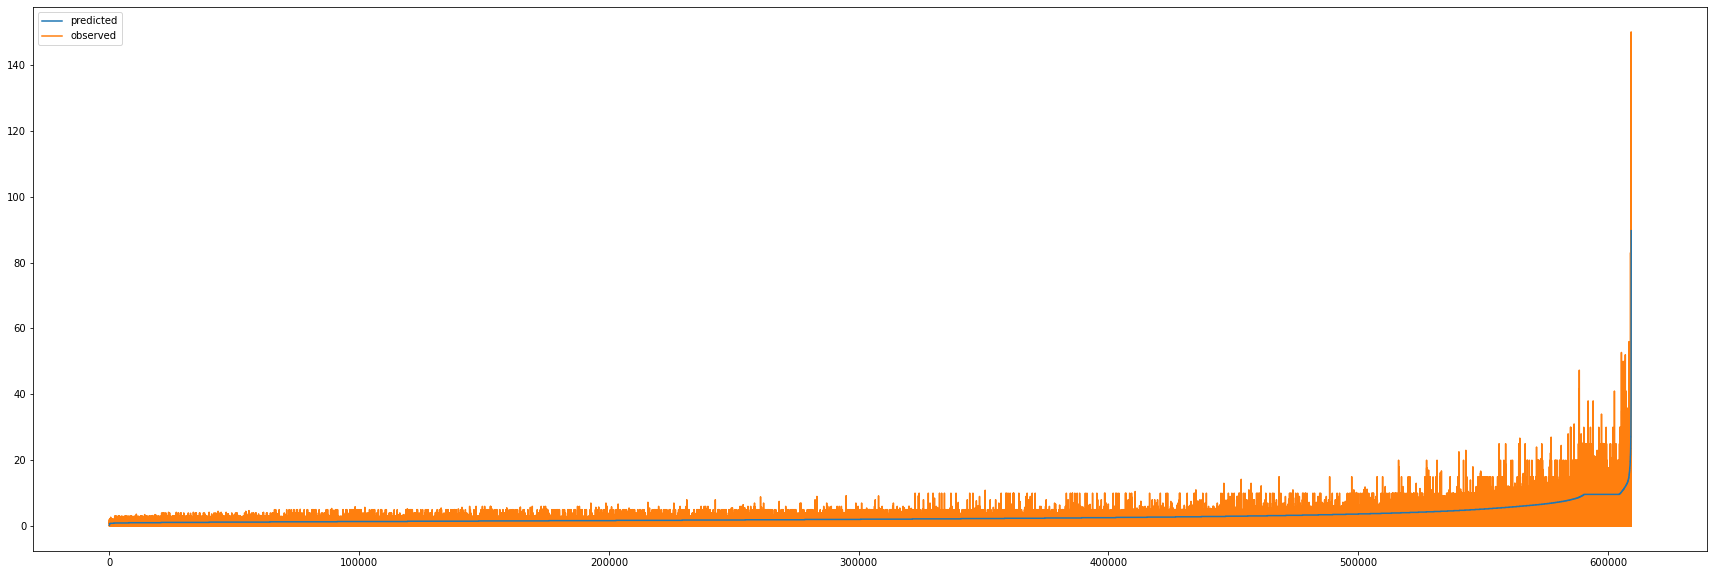

In [166]:
fig,ax = plt.subplots(figsize=(30,10))
ax.plot(labels_test_pred,zorder=100,label="predicted")
ax.plot(labels_test_ordered,label="observed")

plt.legend()

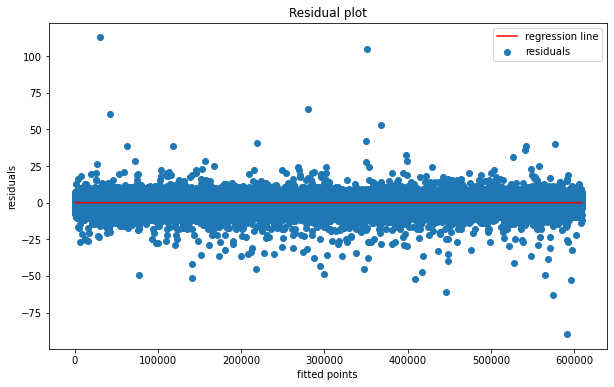

In [167]:
residuals = labels_test - labels_pred

plt.figure(figsize=(10, 6))

f=np.arange(len(residuals))
k = [0 for i in range(len(residuals))]
plt.scatter( f, residuals, label = 'residuals')
plt.plot( f, k , color = 'red', label = 'regression line' )
plt.xlabel('fitted points ')
plt.ylabel('residuals')
plt.title('Residual plot')
plt.legend()




Then I decided to have a take on a spatial approach where I am going to build a model for each of the OD tupples

In [101]:
part_2_train

,trip_distance,duration_s,PULocationID,DOLocationID
165048,18.52,2827,132,234
1997424,0.62,404,237,237
1521747,0.68,398,141,43
2924887,5.70,2113,170,223
410619,3.13,946,144,233
...,...,...,...,...
3132609,0.39,217,162,233
446367,2.03,697,41,239
1047943,4.30,1474,162,231
1029121,0.98,445,75,43


In [168]:
od_tip_data=part_1_train.groupby(["PULocationID","DOLocationID"])['tip_amount'].agg(['mean', 'min', 'max',"count","std"])
od_tip_data.sort_values("count",ascending=False)

mean    min     max  count       std
PULocationID DOLocationID                                           
264          264            2.679818   0.00  100.00  40049  2.601075
237          236            1.443915   0.00   10.55  17141  0.574446
236          237            1.625665   0.00   15.00  13902  0.702481
             236            1.263750   0.00   17.00  13348  0.858442
237          237            1.342556   0.00   25.00  11252  0.993082
...                              ...    ...     ...    ...       ...
216          124            2.760000   2.76    2.76      1       NaN
             117            7.120000   7.12    7.12      1       NaN
             116           11.650000  11.65   11.65      1       NaN
             113           10.000000  10.00   10.00      1       NaN
45           16             0.000000   0.00    0.00      1       NaN

[18790 rows x 5 columns]

In [130]:
od_tip_data.describe()

,mean,min,max,count,std
count,12977.000000,12977.000000,12977.000000,12977.000000,9203.000000
mean,4.622610,2.601925,7.198941,58.691916,1.914312
std,3.505222,3.749774,5.327344,191.651730,1.714249
min,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2.365769,0.000000,4.350000,1.000000,0.945449
50%,3.872000,1.000000,6.350000,4.000000,1.446979
75%,5.941000,4.020000,9.050000,27.000000,2.319883
max,105.050000,105.050000,105.050000,10065.000000,37.847849


In [173]:
modeling_sample=od_tip_data[od_tip_data['count']>3000]
print(len(modeling_sample))

182


In [179]:
r2_scores=[]
mse_scores=[]

linear_regression_performance = {}
index_=0
for tupple_ in modeling_sample.index:
    
    
    zone_tupple_df=part_1_train[(part_1_train['PULocationID']==tupple_[0]) & (part_1_train['DOLocationID']==tupple_[1])]


    data_train, data_test, labels_train, labels_test = train_test_split(zone_tupple_df[['trip_distance',"duration_s","tip_amount","fare_amount"]],
                                                            zone_tupple_df['tip_amount'], test_size=0.20, random_state=42)


    reg = LinearRegression().fit(data_train[["fare_amount"]], labels_train)
    labels_pred = reg.predict(data_test[["fare_amount"]])
    mse_score=skm.mean_squared_error(labels_test, labels_pred)
    r2_score_ = skm.r2_score(labels_test, labels_pred)


    #i will also test if the tupple performs better using the bm 
    labels_pred_bm = reg_bm.predict(data_test[["fare_amount"]])
    mse_score_bm=skm.mean_squared_error(labels_test, labels_pred_bm)
    r2_score_bm = skm.r2_score(labels_test, labels_pred_bm) 

    mean_trained = data_train['tip_amount'].mean()
    mean_vals = [ mean_trained for i in range(len(labels_pred_bm))]
    mse_score_mean=skm.mean_squared_error(mean_vals, labels_pred_bm)
    r2_score_mean = skm.r2_score(mean_vals, labels_pred_bm) 


    linear_regression_performance[tupple_]={"mse_score":mse_score,"r2_score":r2_score_,
                                            "local_coef":reg.coef_,"local_intercept":reg.intercept_,
                                            "mse_score_bm":mse_score_bm,"r2_score_bm":r2_score_bm,
                                             "mse_score_mean":mse_score_mean,"r2_score_mean":r2_score_mean}



    
    if(index_%100==0):
        
        print(len(modeling_sample.index)-index_, "left to go..")
        
        
    index_+=1


182 left to go..
82 left to go..


In [132]:
linear_regression_performance

{(13, 231): {'mse_score': 0.3906129748150652,
  'r2_score': 0.08962781238972051,
  'local_coef': array([0.29593402, 0.00097359]),
  'local_intercept': 0.7686580821296851,
  'mse_score_bm': 0.3877269189829632,
  'r2_score_bm': 0.09635412495698736,
  'mse_score_mean': 0.06214340881941659,
  'r2_score_mean': -3.1510451796064673e+29},
 (43, 43): {'mse_score': 1.016585559931867,
  'r2_score': 0.00522686330906974,
  'local_coef': array([ 5.82488074e-01, -1.41290420e-06]),
  'local_intercept': 0.9563034505042516,
  'mse_score_bm': 1.0013234698750122,
  'r2_score_bm': 0.020161481502283474,
  'mse_score_mean': 0.0895031995316785,
  'r2_score_mean': 0.0},
 (43, 142): {'mse_score': 0.5755416009635848,
  'r2_score': 0.11926044711128903,
  'local_coef': array([6.44045256e-01, 1.83126158e-07]),
  'local_intercept': 0.8593229476366433,
  'mse_score_bm': 0.5553040908675914,
  'r2_score_bm': 0.150229495332451,
  'mse_score_mean': 0.1165540116738089,
  'r2_score_mean': -2.626662450796656e+29},
 (43, 161

In [181]:
r2_scores_,mse_scores_,results_=[],[],[]
edge_list_local = []
edge_list_bm =[]
for keys,val in linear_regression_performance.items():
    
    mse_diff=val['mse_score']-val["mse_score_bm"]
    r2_diff = val['r2_score']-val['r2_score_bm']
    
    better_model="mix"
    if((mse_diff<0) and (r2_diff>0)):
        better_model = "local"
        edge_list_local.append(keys)
    elif((mse_diff>0) and (r2_diff<0)):
        better_model="bm"
        edge_list_bm.append(keys)

        
    linear_regression_performance[keys]['better_model']=better_model
    mse_scores_.append(mse_diff)
    r2_scores_.append(r2_diff)
    results_.append(better_model)

In [265]:
pd.Series(results_).value_counts()

local    114
bm        68
dtype: int64

In [122]:
taxi_df.compute_taxi_zones()
taxi_df.graph_representation()
taxi_df.assign_attributes_to_graph(od_tip_data,["mean","min","max","count","std"])



In [183]:
clear_bm_edgelist =[]
for i in edge_list_bm:
    if(i in list(taxi_df.G_main.edges())):
        clear_bm_edgelist.append(i)
        
clear_local_edgelist =[]
for i in edge_list_local:
    if(i in list(taxi_df.G_main.edges())):
        clear_local_edgelist.append(i)

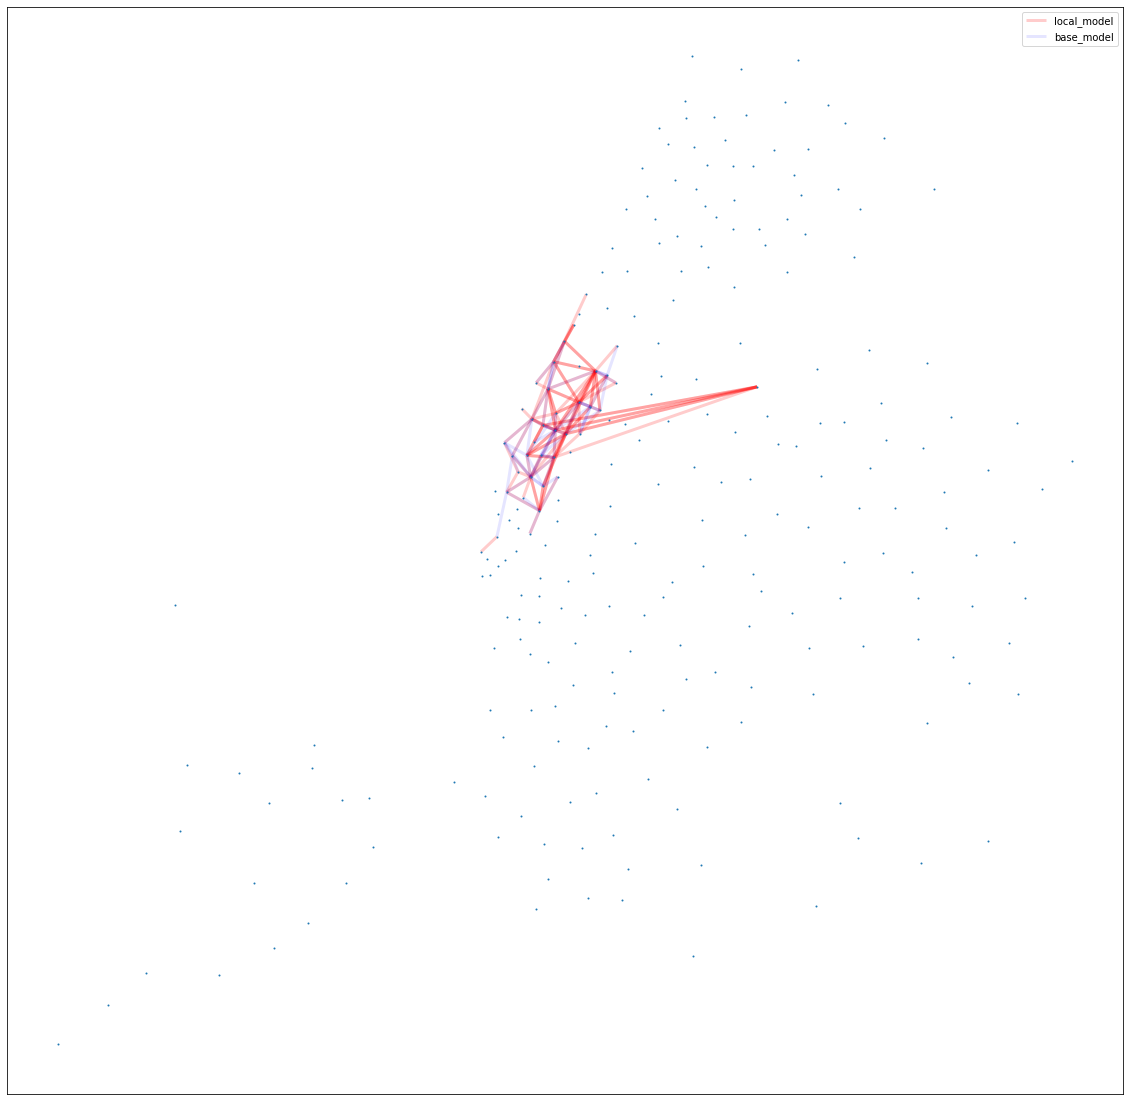

In [184]:
#most of the trips sampled with higher than 7dollar per mile existin in the manhattan area

min_vals=np.array(list(nx.get_edge_attributes(taxi_df.G_main,"std").values()))

        
fig,ax = plt.subplots(figsize=(20,20))
nx.draw_networkx_nodes(taxi_df.G_main,pos=taxi_df.pos,node_size=1,ax=ax)
nx.draw_networkx_edges(taxi_df.G_main,pos=taxi_df.pos,arrows=False,ax=ax,width=3,alpha=0.2,
                       edge_color="red",edgelist=clear_local_edgelist,label="local_model")


nx.draw_networkx_edges(taxi_df.G_main,pos=taxi_df.pos,arrows=False,ax=ax,width=3,alpha=0.1,
                       edge_color="blue",edgelist=clear_bm_edgelist,label="base_model")

plt.legend()

Text(0.5, 1.0, 'R2 scores comparisson')

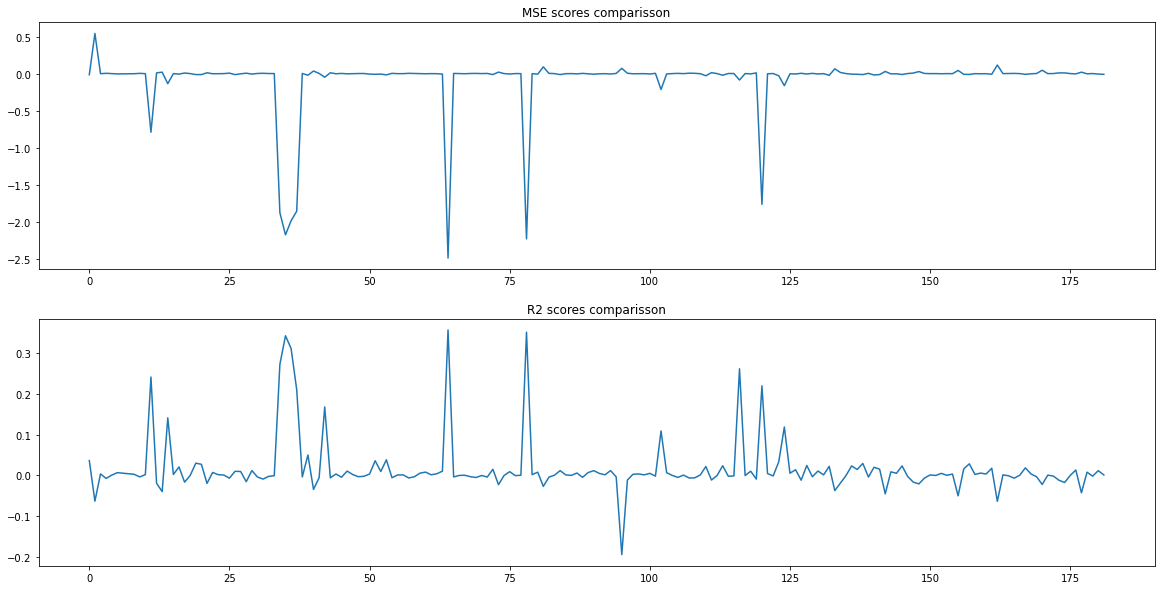

In [185]:
fig,ax = plt.subplots(2,1,figsize=(20,10))

ax[0].plot(mse_scores_)
ax[0].set_title("MSE scores comparisson")

ax[1].plot(r2_scores_)
ax[1].set_title("R2 scores comparisson")


In [267]:
result_df=pd.DataFrame(linear_regression_performance).T
result_df

mse_score  r2_score             local_coef local_intercept  \
13  231  0.317714   0.24375  [0.15714625530568554]        0.427623   
48  48    2.08806  0.757255   [0.1443239814149837]        0.529471   
    50   0.331627  0.234764  [0.18438004213104806]        0.259218   
    68   0.356637  0.305589    [0.135589023407789]        0.626122   
    142  0.310791  0.377076  [0.17441143383369848]        0.365077   
...           ...       ...                    ...             ...   
263 75    0.34422   0.23425  [0.12750075835617478]        0.518991   
    141  0.217122  0.327744  [0.16401100876915714]        0.350848   
    236  0.200325  0.296094  [0.15652097941144474]        0.412911   
    237   0.36034  0.343324  [0.14360955430899025]        0.530845   
264 264   2.83912  0.592254  [0.14284419519575015]        0.763085   

        mse_score_bm r2_score_bm mse_score_mean r2_score_mean better_model  
13  231     0.333089    0.207153       0.239897             0        local  
48  48       1.54614    0.820255         5.2897  -1.07288e+32           bm  
    50      0.333303    0.230896        0.13533             0        local  
    68      0.352936    0.312795       0.192496  -3.90429e+30           bm  
    142     0.311226    0.376204       0.191447    -3.883e+30        local  
...              ...         ...            ...           ...          ...  
263 75      0.325132    0.276713      0.0792659   -1.6077e+30           bm  
    141     0.219745    0.319621       0.125025  -2.53581e+30        local  
    236     0.199858    0.297734      0.0925134             0           bm  
    237     0.366816    0.331522       0.256576             0        local  
264 264      2.84899    0.590837        5.21771             0        local  

[182 rows x 9 columns]

In [276]:
pd.Series(result_df['mse_score'].values).mean()

0.658425381360766

In [187]:
#store the results to a csv 
resultDf=pd.DataFrame(linear_regression_performance).T.reset_index()
resultDf.to_csv("results.csv")

In [188]:
# import pandas as pd

# resultDf=pd.read_csv("results.csv")


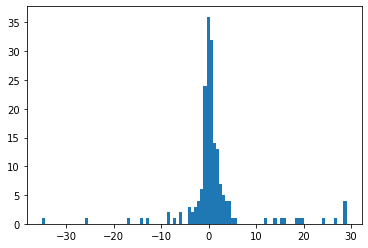

In [189]:
perf=100*(resultDf['mse_score_bm']-resultDf['mse_score'])/resultDf['mse_score_bm']
plt.hist(perf,bins=100)
plt.show()

In [190]:
#some average 
print("Mean MSE", resultDf['mse_score'].mean(), "Mean R2",resultDf['r2_score'].mean())

Mean MSE 0.658425381360766 Mean R2 0.3216422983516764


In [223]:

def local_model_fit(x,attr,bm_model,local_dict):
    
    predictions=[]
    
    for row_ in range(len(x)):

        od_tupple = (x.iloc[row_]["PULocationID"],x.iloc[row_]["DOLocationID"])
        
        if(od_tupple in list(local_dict.keys())):
            if(local_dict[od_tupple]['better_model']=="local"):
                
                pred_label = x.iloc[row_][attr]*local_dict[od_tupple]['local_coef']+local_dict[od_tupple]["local_intercept"]
                
            else:
                pred_label = bm_model.predict(np.array(x.iloc[row_][attr]).reshape(-1,1))
            
        else:
            pred_label = bm_model.predict(np.array(x.iloc[row_][attr]).reshape(-1,1))
            
        
        predictions.append(pred_label)
        
    return predictions

test the local model. I will use the second part of my original dataset to compare the models

In [224]:
pred_labels=local_model_fit(part_2_train,"fare_amount",reg_bm,linear_regression_performance)

In [236]:
print('Mean squared error: %.2f'% skm.mean_squared_error(part_2_test['tip_amount'], pred_labels))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'% skm.r2_score(part_2_test['tip_amount'], pred_labels))

Mean squared error: 2.26
Coefficient of determination: 0.66


In [235]:

labels_pred_bm_general = reg_bm.predict(part_2_train[['fare_amount']])

# The mean squared error
print('Mean squared error: %.2f'% skm.mean_squared_error(part_2_test['tip_amount'], labels_pred_bm_general))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'% skm.r2_score(part_2_test['tip_amount'], labels_pred_bm_general))

Mean squared error: 2.28
Coefficient of determination: 0.66


As an alternative I wanted to see if a rf regressor could do the work and return better results..

In [263]:
from sklearn.ensemble import RandomForestRegressor

regressor_rf = RandomForestRegressor(n_jobs=-1)
regressor_rf.fit(np.array(part_1_train['fare_amount'].values).reshape(-1,1),part_1_test['tip_amount'].values)


RandomForestRegressor(n_jobs=-1)

In [280]:
y_pred_rf = regressor_rf.predict(np.array(part_2_train['fare_amount'].values).reshape(-1,1))


print('RMSE score for the RF regressor is : %.2f' %skm.mean_squared_error(part_2_train['tip_amount'].values,y_pred_rf))
print('Variance score for the RF regressor is : %.2f' % regressor_rf.score(np.array(part_2_train['fare_amount'].values).reshape(-1,1), part_2_test['tip_amount']))

RMSE score for the RF regressor is : 2.14
Variance score for the RF regressor is : 0.68
